In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_small'

df = pd.read_csv(froot + ".csv")

In [2]:
print(df.head())

   seqnames     start       end strand  ensembl_gene_id  score      ctcf  \
0         6  41077441  41077441      +  ENSG00000001167    0.0 -0.074159   
1         6  41077442  41077442      +  ENSG00000001167    0.0 -0.074217   
2         6  41077443  41077443      +  ENSG00000001167    0.0 -0.074276   
3         6  41077444  41077444      +  ENSG00000001167    0.0 -0.074336   
4         6  41077445  41077445      +  ENSG00000001167    0.0 -0.074398   

   h3k36me3   h3k4me1  h3k79me2  ...       sj3       dms      rpts  wgbs  \
0 -0.347414 -0.231637  1.630302  ... -0.057178 -0.307549  0.249626   0.0   
1 -0.346807 -0.231970  1.628545  ... -0.057178 -0.307549  0.249626   0.0   
2 -0.346199 -0.232304  1.626748  ... -0.057178 -0.307549  0.249626   0.0   
3 -0.345591 -0.232638  1.624913  ... -0.057178 -0.307549  0.249626   0.0   
4 -0.344983 -0.232972  1.623041  ... -0.057178 -0.307549  0.249626   0.0   

       A         T         G         C  lambda_alphaj      zeta  
0 -0.625  1.473964 -

In [3]:
df['gene_length'] = df.groupby('ensembl_gene_id')['ensembl_gene_id'].transform('count')

In [4]:
column_names = df.columns.tolist()
feature_names = column_names[6:-7]
nucleotides = column_names[-7:-3]
print(feature_names)
print(nucleotides)

# process read counts
X_ji = df.groupby('ensembl_gene_id')['score'].apply(list).tolist() 

# process GLM simulated elongation rates
Z_ji = df.groupby('ensembl_gene_id')['zeta'].apply(list).tolist() 

num_samples = len(X_ji)

['ctcf', 'h3k36me3', 'h3k4me1', 'h3k79me2', 'h3k9me1', 'h3k9me3', 'h4k20me1', 'sj5', 'sj3', 'dms', 'rpts', 'wgbs']
['A', 'T', 'G', 'C']


In [5]:
from sklearn.preprocessing import MinMaxScaler

#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   [[sample_1_feature_1], [sample_1_feature_2], [sample_1_feature_3]],
    #   [[sample_2_feature_1], [sample_1_feature_2], [sample_1_feature_3]],  
    # ]

Y_ji = []

for sample_id in df['ensembl_gene_id'].unique():
    sample_data = [df[feature_name][df['ensembl_gene_id'] == sample_id].tolist() for feature_name in feature_names]
    Y_ji.append(sample_data)

In [6]:
# normalize features
scaler = MinMaxScaler()
Y_ji = np.array(Y_ji)
# reshape dataset to [num_samples, num_features * feature_length]
Y_ji_reshaped = Y_ji.reshape(Y_ji.shape[0], -1)
normalized_Y_ji_reshaped = scaler.fit_transform(Y_ji_reshaped)
Y_ji = normalized_Y_ji_reshaped.reshape(Y_ji.shape)

In [7]:
C_j = df.groupby('ensembl_gene_id')['lambda_alphaj'].apply(list).tolist() 

In [8]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, Y_ji, X_ji, C_j, Z_ji):
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.X_ji)

    def __getitem__(self, idx):
        return {
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [9]:
dataset = CustomDataset(Y_ji, X_ji, C_j, Z_ji)

trnset, valset, tstset = td.random_split(dataset, [0.5,0.25,0.25])

trndl = DataLoader(trnset, batch_size=64, shuffle=True)
tstdl = DataLoader(tstset, batch_size=64, shuffle=False)
valdl = DataLoader(valset, batch_size=64, shuffle=False)

Model(
  (net): Sequential(
    (0): Conv1d(12, 32, kernel_size=(5,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=12288, out_features=6144, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=6144, out_features=200, bias=True)
  )
)
torch.Size([64, 200])
Number of parameters: 76744872


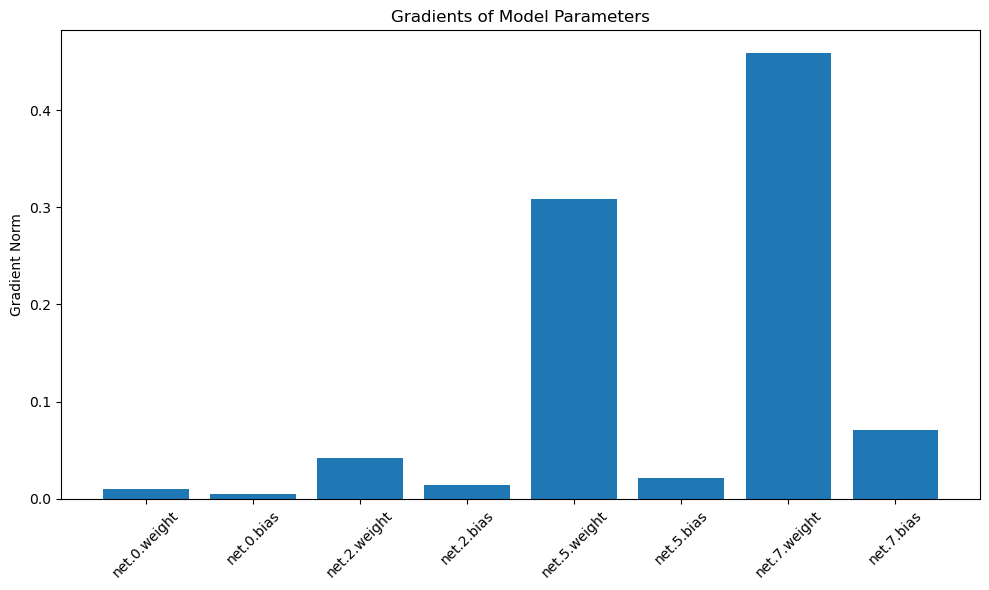

In [19]:
import torch.nn as nn

conv_kernel_size=5
final_output_channel = 64
sequence_len = 200
linear_input = final_output_channel * (sequence_len - (2 * (conv_kernel_size - 1)))

class Model(nn.Module):
    def __init__(self):
       super(Model, self).__init__()
       self.net = nn.Sequential(
           nn.Conv1d(in_channels=12, out_channels=32, kernel_size=conv_kernel_size),
           nn.LeakyReLU(),
           nn.Conv1d(in_channels=32, out_channels=64, kernel_size=conv_kernel_size),
           nn.Flatten(start_dim=1),
           nn.Dropout(p=0.5),
           nn.Linear(linear_input, linear_input//2),
           nn.LeakyReLU(),
           nn.Linear(linear_input//2, 200))
    def forward(self, x):
        for layer in self.net:
            x = layer(x)
            #print(x.size())
        return x

# input size: [50, 12, 2000]
model = Model()
print(model)

arr = torch.randn((64,12,200))
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

output = model(arr)

# Compute gradients
output.mean().backward()

# Plot gradients
gradient_list = []
parameter_names = []

for name, param in model.named_parameters():
    if param.grad is not None:
        gradient_list.append(param.grad.norm().item())
        parameter_names.append(name)

plt.figure(figsize=(10, 6))
plt.bar(parameter_names, gradient_list)
plt.ylabel('Gradient Norm')
plt.title('Gradients of Model Parameters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        epsilon = 1e-8
        clipped_Z_ji = torch.clamp(Z_ji, epsilon)
        loss = X_ji * torch.log(clipped_Z_ji) + C_j * torch.exp(-clipped_Z_ji)
        # compute mean over batch to normalize due to varying batch sizes
        return loss.mean() 

In [36]:
def plot_data(targets, outputs):
    indices = range(len(targets[0]))

    fig, axs = plt.subplots(3, 3, figsize=(15,15))
    for i in range(3):
        for j in range(3):
            axs[i, j].scatter(indices, targets[i+j*3], s=5)
            axs[i, j].scatter(indices, outputs.detach().numpy()[i+j*3], s=5)
            axs[i, j].set_ylim(-1, 1.3)

    plt.xlabel('Index')
    plt.ylabel('Elongation Rates')
    plt.legend(['GLM Elongation Rate', 'NN Elongation Rate'], loc='upper center', bbox_to_anchor=(0.5, -0.6))


In [49]:
import torch.optim.lr_scheduler as lr_scheduler

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


num_epochs = 50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()#nn.L1Loss()#nn.MSELoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    for batch in trndl:
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji']
        X_ji_batch = batch['X_ji']
        C_j_batch = batch['C_j']
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        #loss = loss_fn(batch['Z_ji'], outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
        #if epoch == 49:
            #plot_data(batch['Z_ji'], outputs)
    loss_hist_train[epoch] /= len(trndl.dataset)
    scheduler.step()
    
    model.eval()
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji']
            X_ji_batch = batch['X_ji']
            C_j_batch = batch['C_j']
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            #loss = loss_fn(batch['Z_ji'], outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl.dataset)
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1
Epoch 1 trn_loss: -0.0056 val_loss: -0.0075
Epoch 2
Epoch 2 trn_loss: -0.0071 val_loss: -0.0076
Epoch 3
Epoch 3 trn_loss: -0.0071 val_loss: -0.0076
Epoch 4
Epoch 4 trn_loss: -0.0071 val_loss: -0.0077
Epoch 5
Epoch 5 trn_loss: -0.0071 val_loss: -0.0074
Epoch 6
Epoch 6 trn_loss: -0.0071 val_loss: -0.0075
Epoch 7
Epoch 7 trn_loss: -0.0071 val_loss: -0.0075
Epoch 8
Epoch 8 trn_loss: -0.0071 val_loss: -0.0075
Epoch 9
Epoch 9 trn_loss: -0.0071 val_loss: -0.0072
Epoch 10
Epoch 10 trn_loss: -0.0071 val_loss: -0.0076
Epoch 11
Epoch 11 trn_loss: -0.0071 val_loss: -0.0076
Epoch 12
Epoch 12 trn_loss: -0.0071 val_loss: -0.0075
Epoch 13
Epoch 13 trn_loss: -0.0071 val_loss: -0.0071
Epoch 14
Epoch 14 trn_loss: -0.0070 val_loss: -0.0072
Epoch 15
Epoch 15 trn_loss: -0.0071 val_loss: -0.0075
Epoch 16
Epoch 16 trn_loss: -0.0071 val_loss: -0.0074
Epoch 17
Epoch 17 trn_loss: -0.0072 val_loss: -0.0079
Epoch 18
Epoch 18 trn_loss: -0.0071 val_loss: -0.0079
Epoch 19
Epoch 19 trn_loss: -0.0071 val_loss: 

<function matplotlib.pyplot.show(close=None, block=None)>

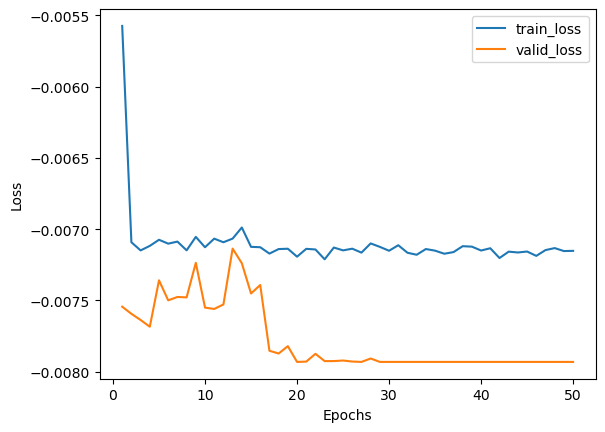

In [50]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

number of samples: 4
tensor([[1.4437e-04, 3.6832e-08, 1.5349e-04,  ..., 5.2692e-04, 6.2725e-09,
         9.9176e-06],
        [9.0026e-04, 6.6090e-07, 9.2304e-04,  ..., 2.4933e-03, 5.1312e-07,
         1.6078e-04],
        [1.4341e-06, 3.4118e-12, 1.2982e-06,  ..., 8.0757e-06, 3.5714e-13,
         2.5059e-08],
        ...,
        [6.6980e-04, 8.4063e-07, 1.0080e-03,  ..., 2.3938e-03, 1.3956e-07,
         7.1899e-05],
        [5.2128e-04, 4.1859e-07, 6.1956e-04,  ..., 1.5796e-03, 9.7162e-08,
         4.4498e-05],
        [6.5875e-04, 8.6870e-07, 1.0887e-03,  ..., 2.2302e-03, 1.3080e-07,
         6.4219e-05]])


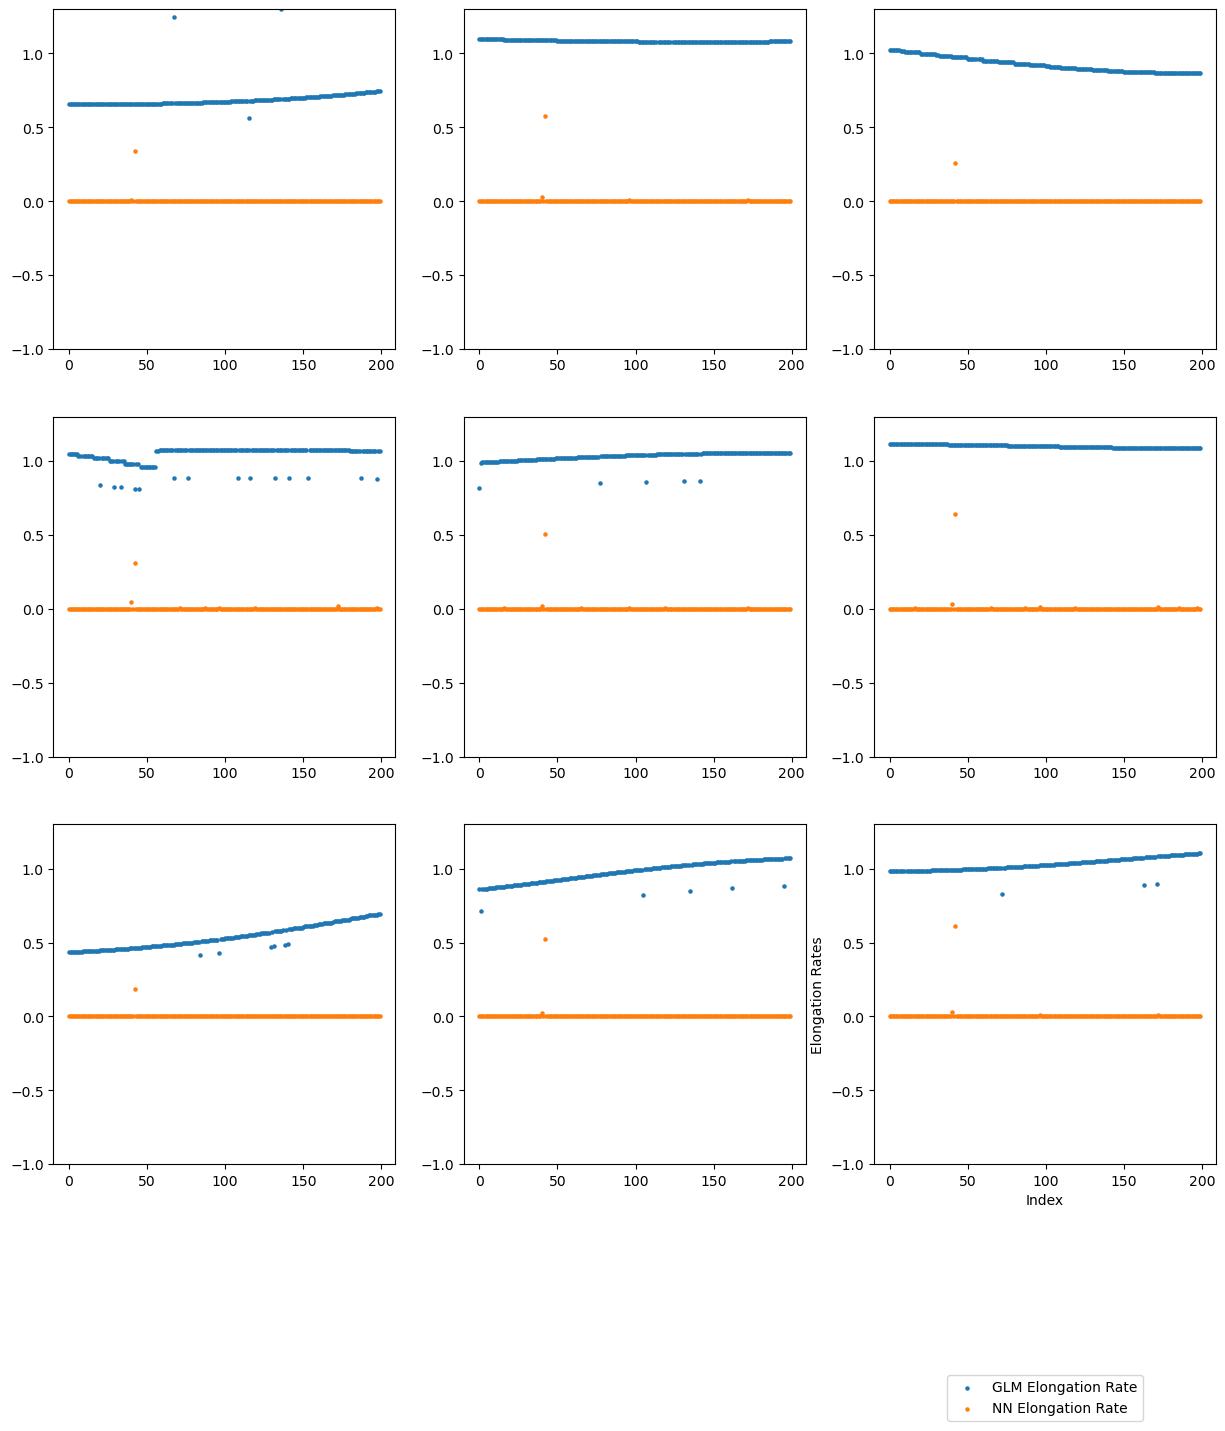

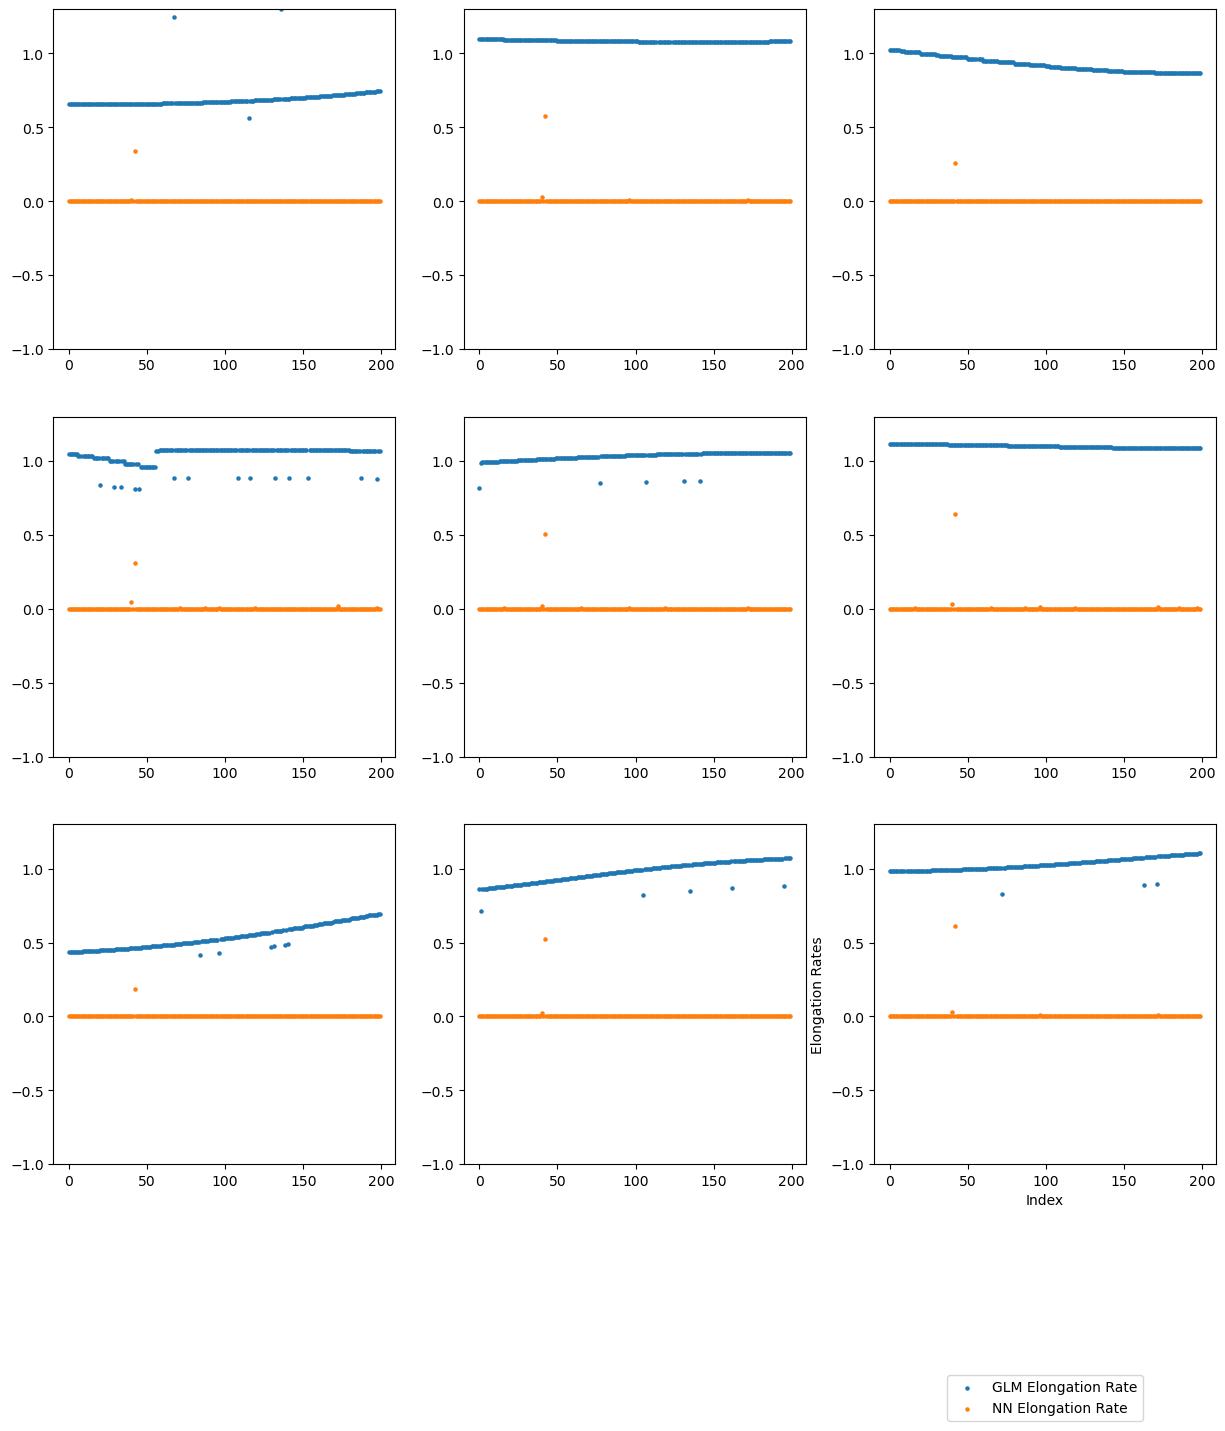

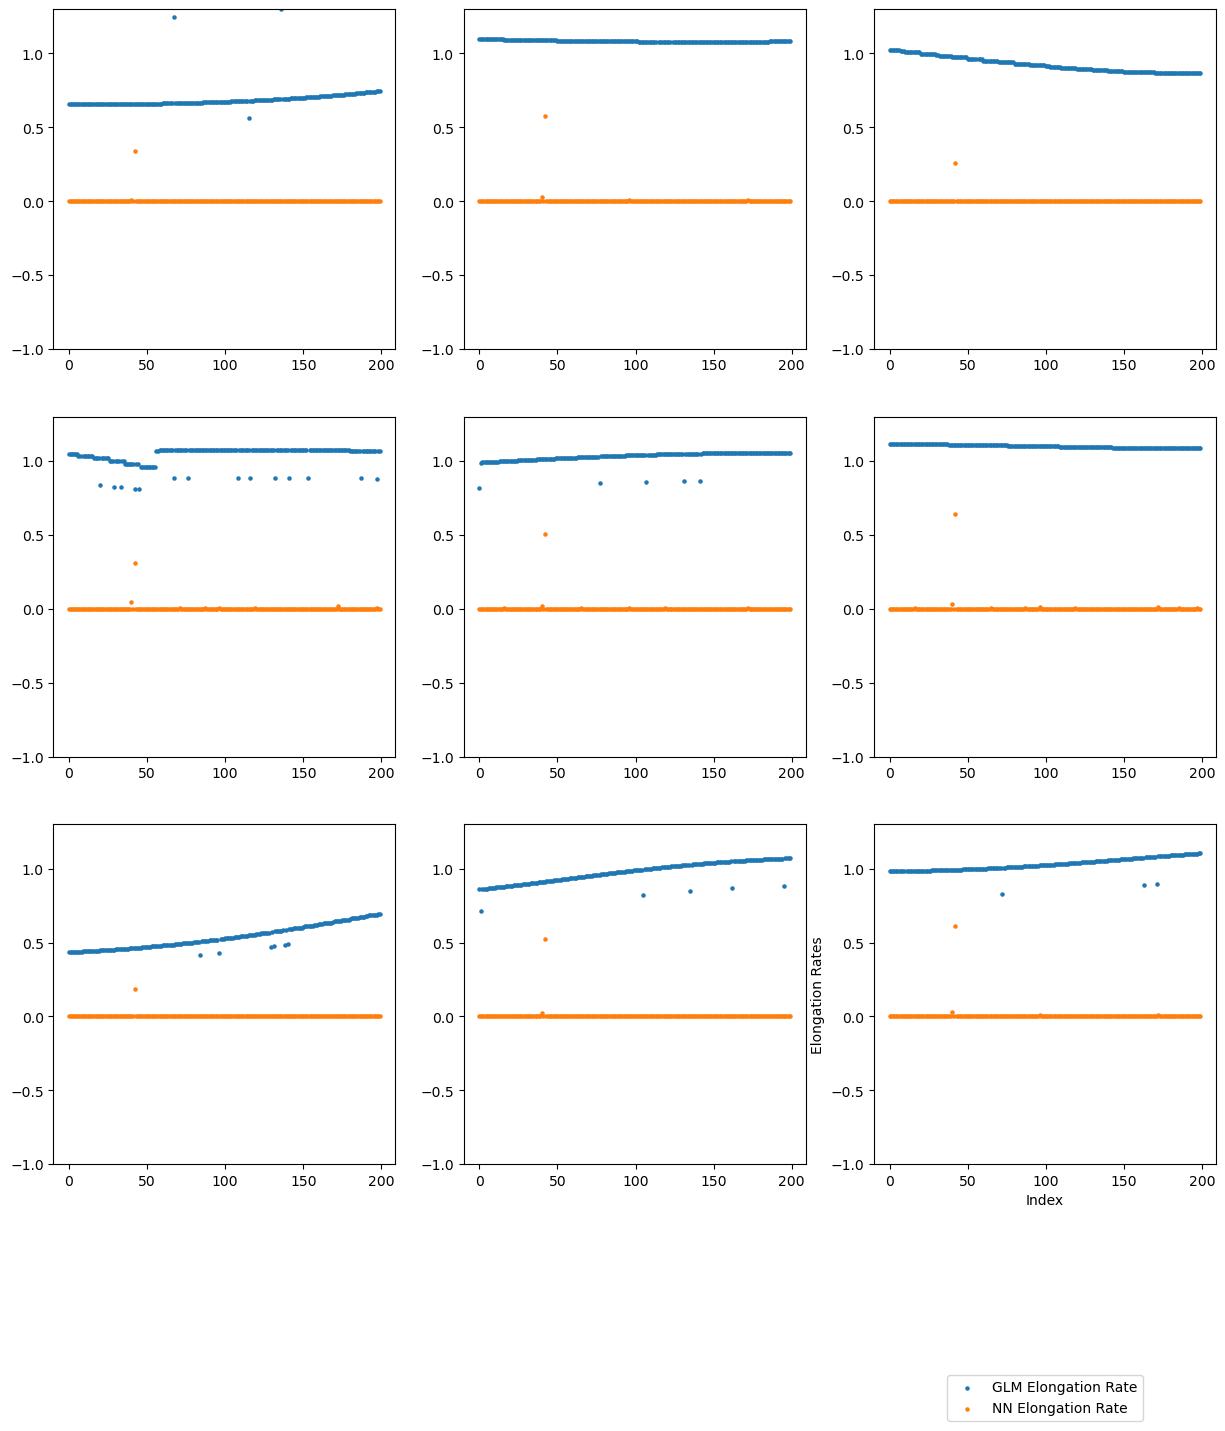

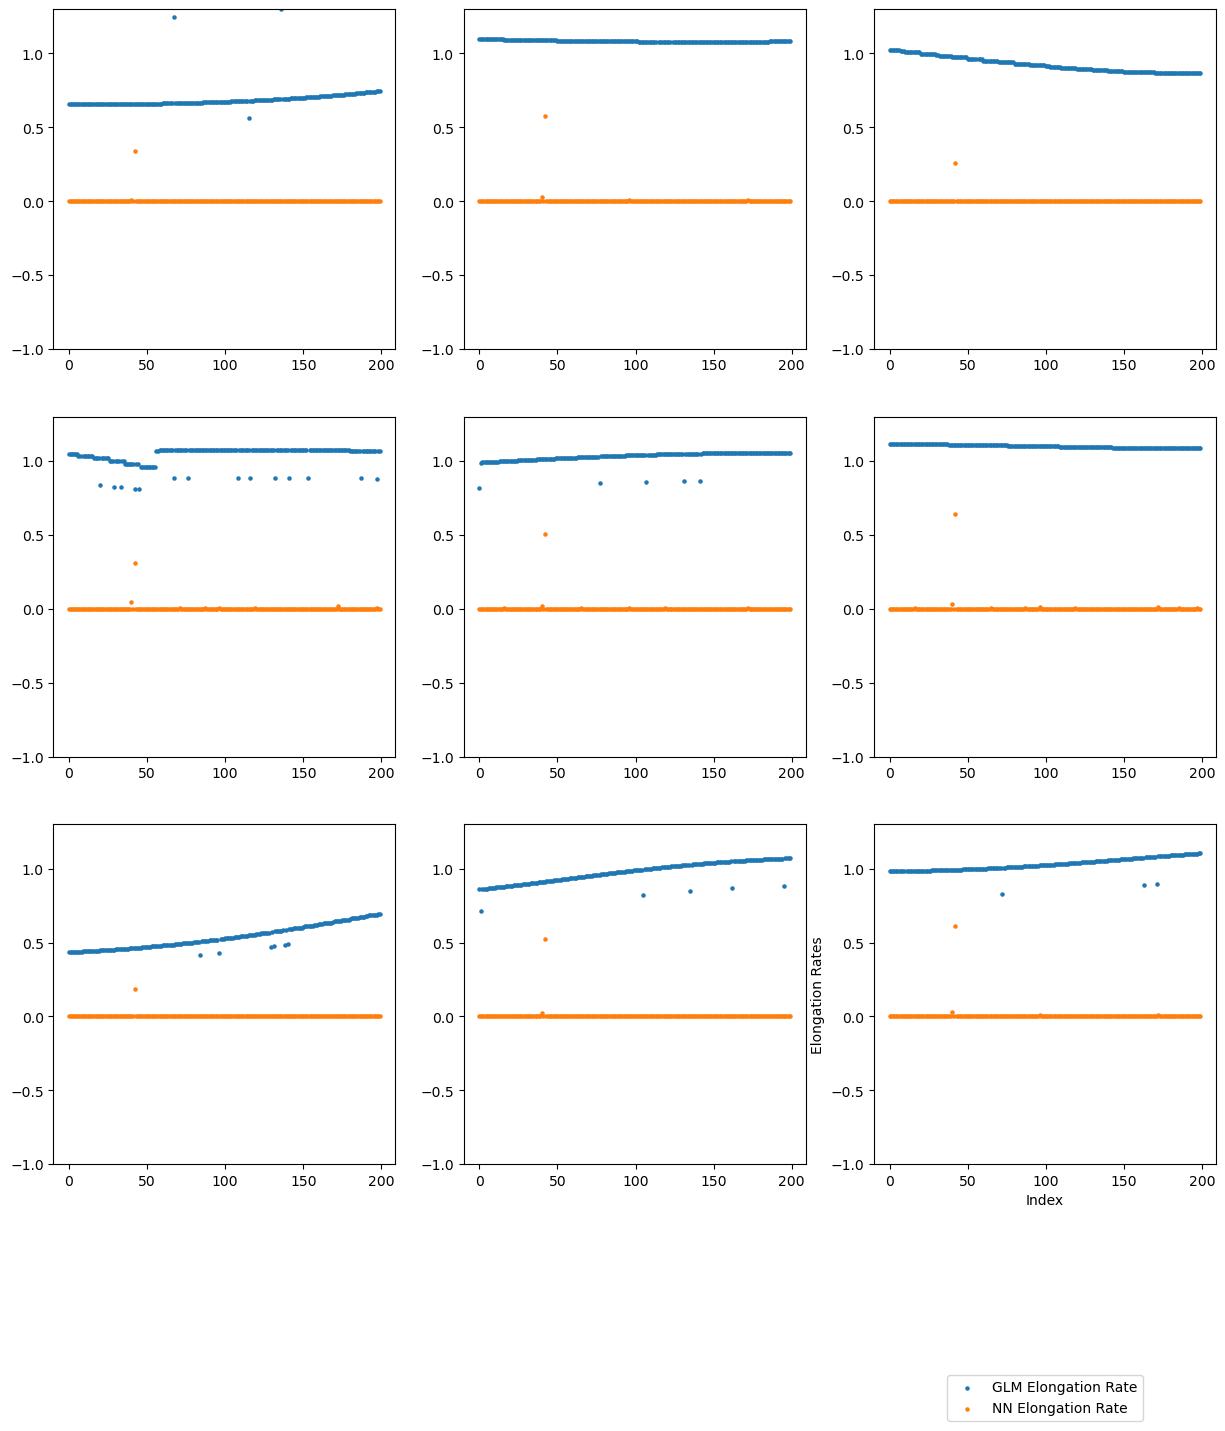

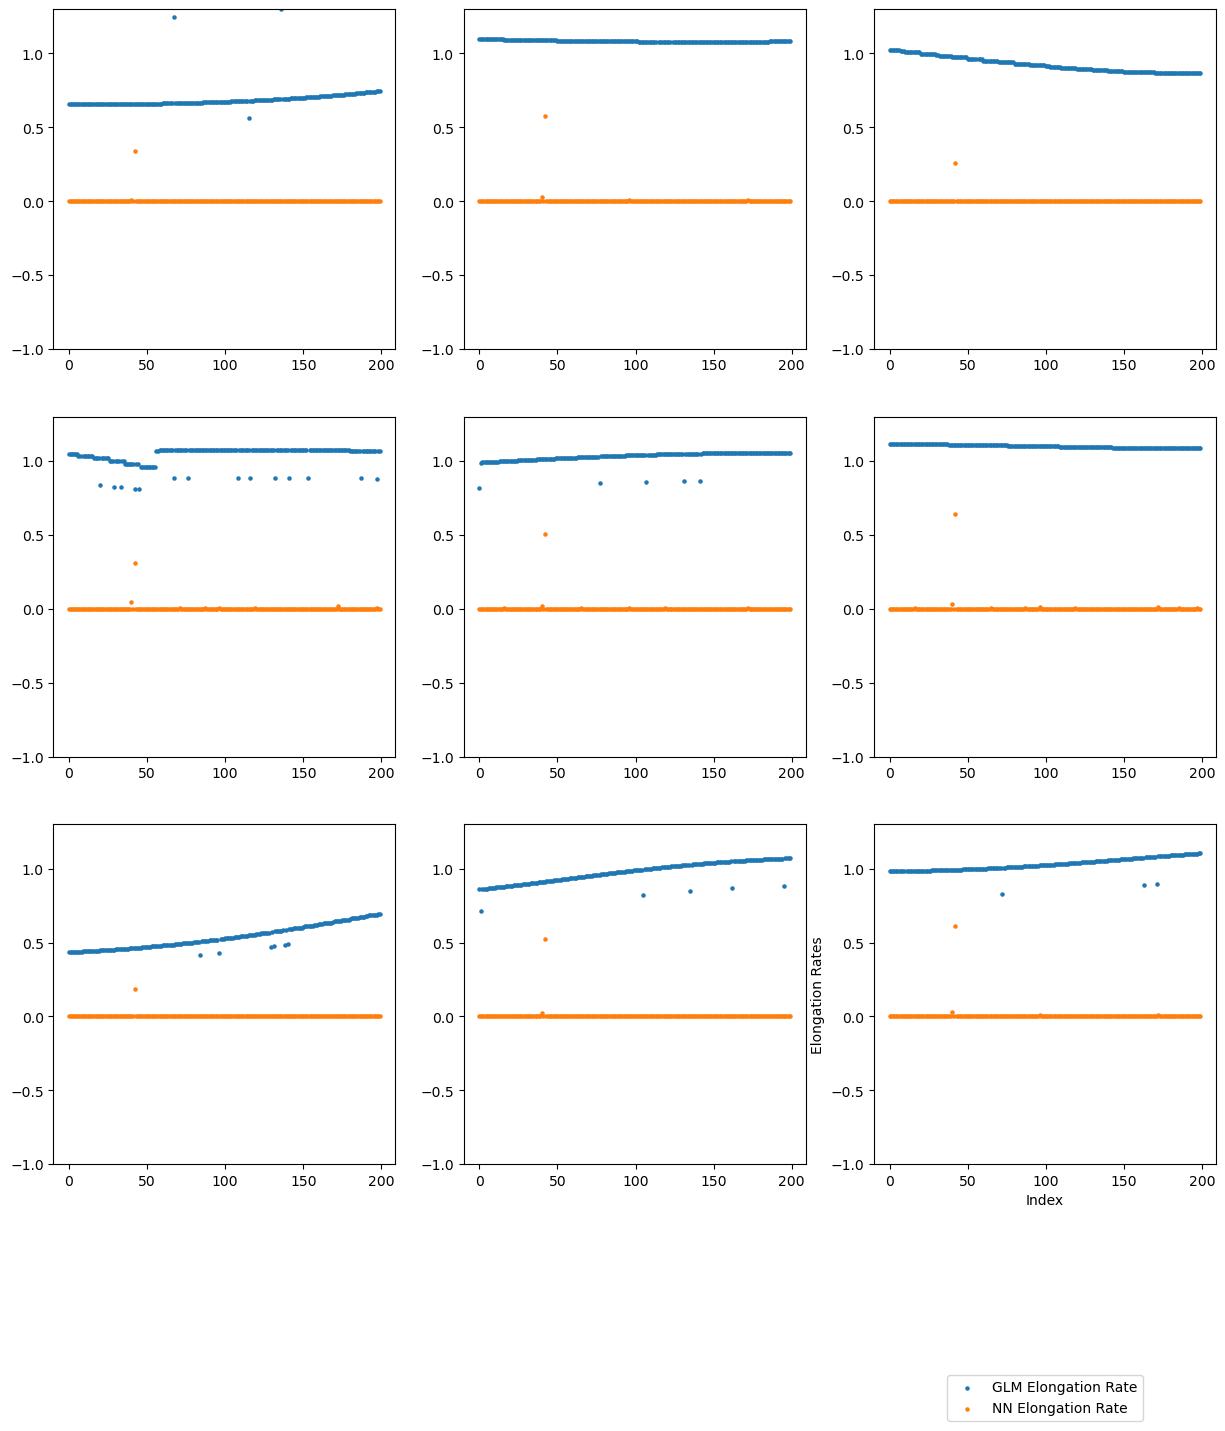

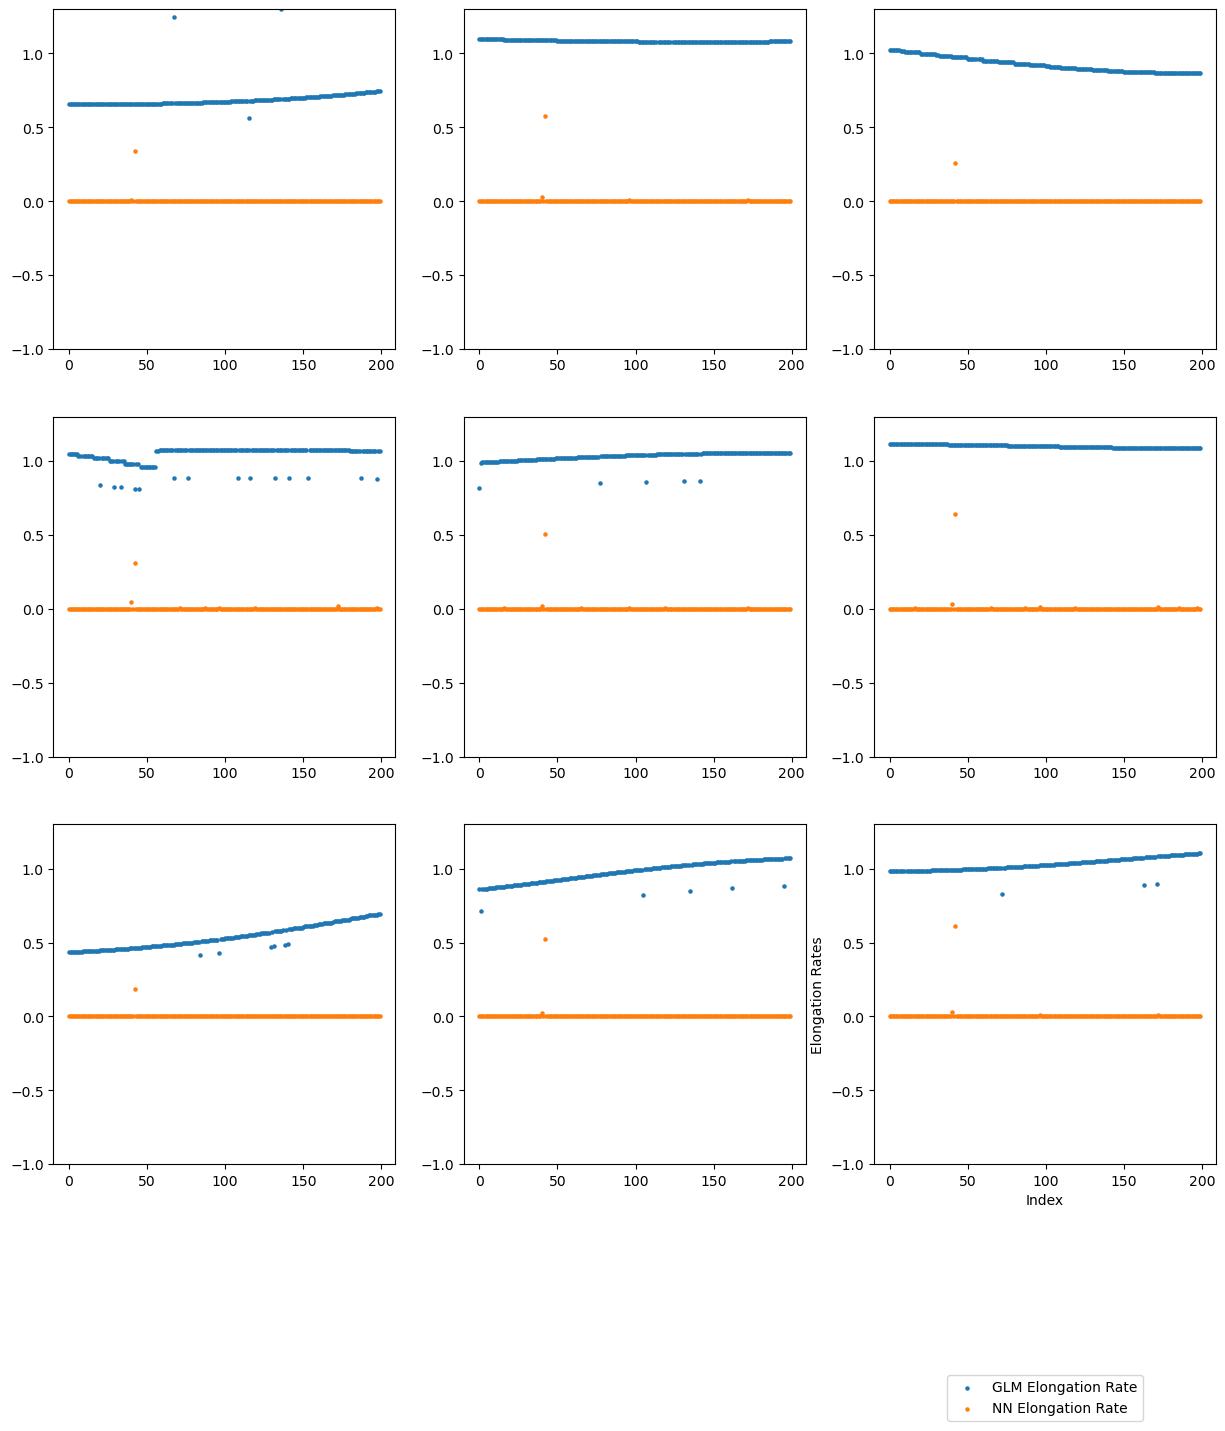

In [53]:
model.eval()

inputs = next(iter(tstdl)) 
print("number of samples: " + str(len(inputs)))

with torch.no_grad():
    outputs = model(inputs['Y_ji'])
    
outputs = torch.exp(outputs)
print(outputs)

targets = inputs['Z_ji']

for batch in tstdl:
    targets = inputs['Z_ji']
    outputs = model(inputs['Y_ji'])
    outputs = torch.exp(outputs)
    
    plot_data(targets, outputs)